# Seminar 1. EEG analysis

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1H81W_DpkHv-ZC9bEbOBW9zfcOe7SCDnR?usp=sharing)

**Plan**

1. Read and visualize the data
2. Preprocess the data
3. Use ICA for noise reduction
4. Compute ERP and plot topomaps for ERP
5. Compute beta band envelopes for ERP
6. Compute coherence

## Part 1

All preprocessing and some data analysis of EEG data can be done using the [Python library MNE](https://mne.tools/stable/auto_tutorials/index.html).

### Data: loading/reading PhysioNet EEG Motor Movement/Imagery. For demonstration, we use a single recording: S003R03.edf (+ .event).

In [1]:
# For Colab only
# ! pip install mne
# ! pip install mne-connectivity

In [2]:
import warnings
warnings.filterwarnings('ignore')
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import mne_connectivity

In [82]:
# not in colab
# %matplotlib notebook
# in colab
%matplotlib inline

mne.io includes the funtions for different EEG-record formats:
https://mne.tools/stable/documentation/implementation.html#supported-data-formats

We will work with data for one patient from [EEG Motor Movement/Imagery Dataset](https://www.physionet.org/content/eegmmidb/1.0.0/).

In [4]:
!wget "https://www.physionet.org/files/eegmmidb/1.0.0/S003/S003R03.edf"

--2025-09-02 02:05:13--  https://www.physionet.org/files/eegmmidb/1.0.0/S003/S003R03.edf
Распознаётся www.physionet.org (www.physionet.org)… 18.18.42.54
Подключение к www.physionet.org (www.physionet.org)|18.18.42.54|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 2596896 (2,5M) [application/octet-stream]
Сохранение в: «S003R03.edf.1»

S003R03.edf.1       100%[===================>]   2,48M   587KB/s    за 4,3s    

2025-09-02 02:05:18 (593 KB/s) - «S003R03.edf.1» сохранён [2596896/2596896]



In [5]:
!wget "https://www.physionet.org/files/eegmmidb/1.0.0/S003/S003R03.edf.event"

--2025-09-02 02:05:18--  https://www.physionet.org/files/eegmmidb/1.0.0/S003/S003R03.edf.event
Распознаётся www.physionet.org (www.physionet.org)… 18.18.42.54
Подключение к www.physionet.org (www.physionet.org)|18.18.42.54|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 638 [text/plain]
Сохранение в: «S003R03.edf.event.1»

S003R03.edf.event.1 100%[===================>]     638  --.-KB/s    за 0s      

2025-09-02 02:05:19 (76,1 MB/s) - «S003R03.edf.event.1» сохранён [638/638]



In [6]:
# !ls

In [7]:
sample = mne.io.read_raw_edf('S003R03.edf', verbose=False, preload=True)

Get some info about a record

In [8]:
sample.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>

In [9]:
print("Sampling freq:", sample.info["sfreq"], "Hz")

Sampling freq: 160.0 Hz


In [10]:
print("Duration (s):", len(sample) / sample.info["sfreq"])

Duration (s): 125.0


In [11]:
print("N channels:", len(sample.ch_names))


N channels: 64


```{admonition} Reflection: data exploration
1. **How many channels and what is the sampling frequency? Why is it important to know this?**  
2. **What modality and experimental paradigm are used?**  
3. **What artifacts can be expected and why?**  
```

### Channel selection and adding a montage

In [12]:
sample.ch_names[:3]

['Fc5.', 'Fc3.', 'Fc1.']

```{admonition} Fixing trailing dots in channel names
:class: dropdown

In some EEG recordings, channel names contain trailing dots (e.g., `Fc3.`).  
Fix this using the `rename_channels` method.

```python

# create a mapping: old name → new name (without dot)
map = {}
for ch in sample.ch_names:
    map[ch] = ch.replace(".", "")

# apply renaming
sample.rename_channels(map)

# check the first channels
print(sample.ch_names[:10])
```
```

In [13]:
map = {}
for ch in sample.ch_names:
    map[ch] = ch.replace(".", "")
sample.rename_channels(map)

<RawEDF | S003R03.edf, 64 x 20000 (125.0 s), ~9.8 MiB, data loaded>

In [14]:
sample.ch_names[:3]

['Fc5', 'Fc3', 'Fc1']

```{admonition} Why select exactly these 19 channels?
:class: dropdown

We restrict the analysis to the **classic 19 electrodes of the 10–20 system**.  
This ensures comparability with textbooks and standard ERP protocols.

- **A1/A2 are not included** → they are ear electrodes, not always present.  
- **MNE uses an extended version** of the 10–20 montage (closer to 10–10), so some labels differ:
  - T3 = T7, T4 = T8  
  - T5 = P7, T6 = P8  
- **Why this matters**: when reading old papers (T3/T4 notation) or working with datasets using different conventions, you must map them consistently.  
- **Takeaway**: consistent channel selection = reproducible and interpretable analysis.
```

In [15]:
channels_to_use = [
    # prefrontal
    'Fp1',
    'Fp2',
    # frontal
    'F7',
    'F3',
    'F4',
    'Fz',
    'F8',
    # central and temporal
    'T7',
    'C3',
    'Cz',
    'C4',
    'T8',
    # parietal
    'P7',
    'P3',
    'Pz',
    'P4',
    'P8',
    # occipital
    'O1',
    'O2',
]

In [16]:
sample_1020 = sample.copy().pick(channels_to_use)

# check that everything is OK
assert len(channels_to_use) == len(sample_1020.ch_names)

In [17]:
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
len(ten_twenty_montage.ch_names) #This command shows how many channels are embedded in the standard 10–20 montage we loaded. In MNE it is an extended version, so the number will be much greater than 19.

94

	1.	mne.channels.make_standard_montage('standard_1020')
        – Creates a montage object (electrode layout) for the standard 10–20 system.
        – It contains 3D coordinates (x, y, z) of each electrode on the scalp.
        – Essentially, it is a “map” of electrode positions.

In [18]:
sample_1020.set_montage(ten_twenty_montage)

<RawEDF | S003R03.edf, 19 x 20000 (125.0 s), ~2.9 MiB, data loaded>

	2.      raw_1020.set_montage(mont)
        – Assigns this map to the raw_1020 object.
        – Each EEG channel now has a known spatial position.
        – Required for topomaps, sensor plots, connectivity

<IPython.core.display.Javascript object>

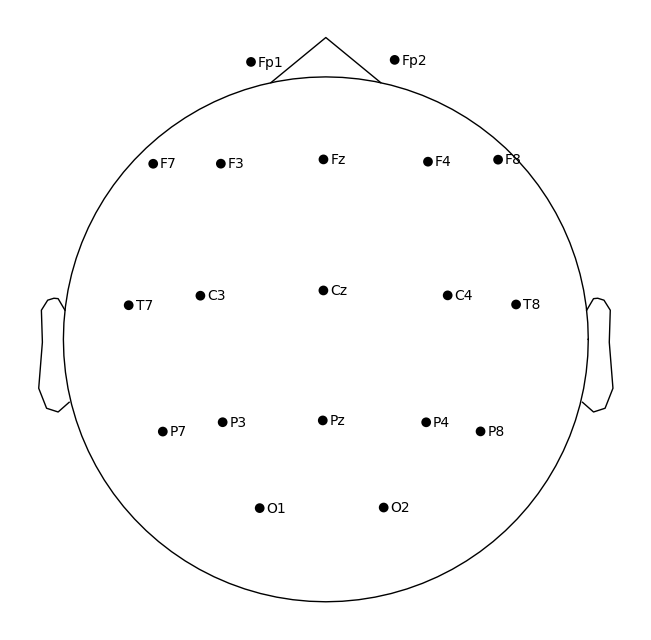

In [19]:
sample_1020.plot_sensors(show_names=True)

```{admonition} Reflection: montage
:class: dropdown

**Q1. Why is it important to standardize/normalize channel names before analysis?**  
**Q2. Why do we need to set a montage? What problems arise for topomaps if we skip it?**  
**Q3. Which of the selected 10–20 channels are located over the motor cortex?**  
**Q4. How can you distinguish temporal from occipital channels in the 10–20 scheme?**  
```

### Checking and Cleaning EEG Spectrum

We first inspect the power spectrum (PSD) to detect line noise and drifts.

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


<IPython.core.display.Javascript object>

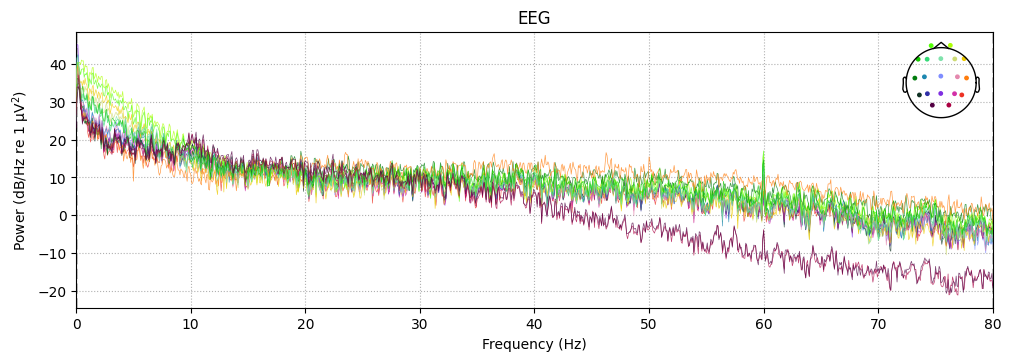

In [20]:
sample_1020.compute_psd().plot()

#### 1. Main signal energy is concentrated in low frequencies (<10 Hz)  
This reflects basic EEG physiology: in humans, most of the power lies in slow oscillations.  

- **1–4 Hz (delta)** — dominant during sleep, but also partly present as background during wakefulness.  
- **4–8 Hz (theta)** — associated with drowsiness and attention.  
- **8–13 Hz (alpha)** — typical for occipital areas, especially with eyes closed.  

The fact that low frequencies dominate the spectrum confirms that this is real EEG, not just noise.  


####  2. Weak 50/60-Hz peak  
In real recordings, a *spike* at the power line frequency (50 Hz in Europe, 60 Hz in North America) is often visible.  

Here it is weak, which means:  
- either the equipment was well shielded,  
- or the artifact was attenuated by the filter (`h_freq=50` (60)).  

➡️ This is convenient: a separate notch filter is not required.

- **What The [notch filter](https://mne.tools/stable/generated/mne.filter.notch_filter.html#mne-filter-notch-filter) does:** it is a *targeted filter* that removes a narrow band around a single frequency (e.g., exactly 50 or 60 Hz).  
- **Why:** the power grid operates at a fixed frequency (50/60 Hz), and this activity “leaks” into EEG recordings as a characteristic spike in the spectrum.  
- **Problem:** this activity is not brain-related but can mask real neural rhythms.  
- **Solution:** the notch filter selectively removes this noise while preserving neighboring frequencies (e.g., the alpha rhythm at 10 Hz or the beta rhythm at 20 Hz).  

#### Band-pass filtering

➡️ We apply a band-pass filter (1–50 Hz) to preserve only brain rhythms and remove drift and noise. For this, we use a digital IIR filter, which works efficiently and is applied in MNE in a safe zero-phase mode without time distortion.

In [21]:
sample_1020.filter(l_freq=1, h_freq=50, method='iir')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 50.00 Hz: -6.02, -6.02 dB



<RawEDF | S003R03.edf, 19 x 20000 (125.0 s), ~2.9 MiB, data loaded>

```{admonition} Ploting psd after filtering
:class: dropdown

```python

sample_1020.compute_psd().plot()
```
```

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


<IPython.core.display.Javascript object>

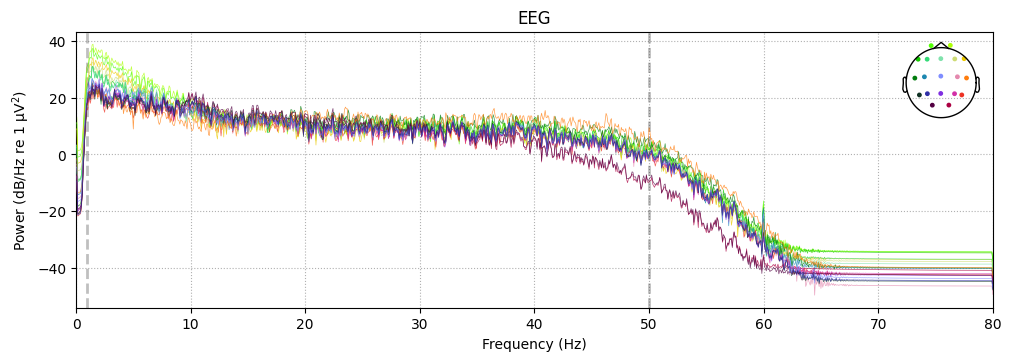

In [22]:
sample_1020.compute_psd().plot()

```{admonition} Reflection: filtering
:class: dropdown

**Q1. What is the difference between a notch and a band-pass filter? Why are both steps useful?**  
**Q2. Why is it better to filter after setting the montage?**  
**Q3. What does 1–50 Hz mean for EEG? Which physiological rhythms are preserved or removed?**  
**Q4. Why is drift <1 Hz undesirable for ERP analysis?**  
```

#### Plot EEG signals

We display several EEG channels on the screen for 20 seconds to visually check signal quality and detect artifacts that are not always visible in the spectrum. However, it is important to adjust the scalings parameter for proper visualization.

Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>

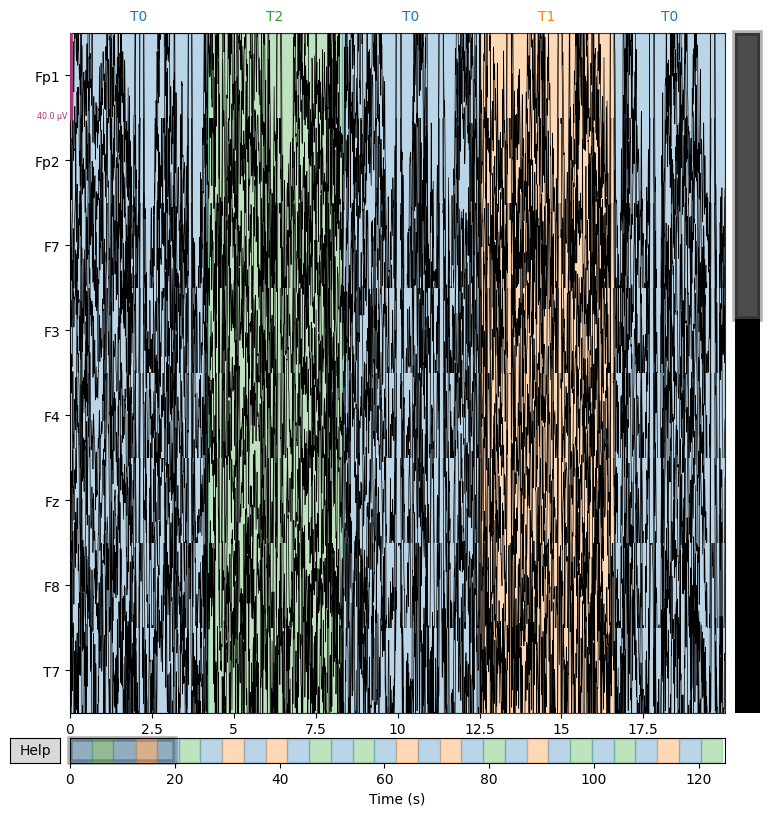

In [23]:
sample_1020.plot(n_channels=8, duration=20)

<IPython.core.display.Javascript object>

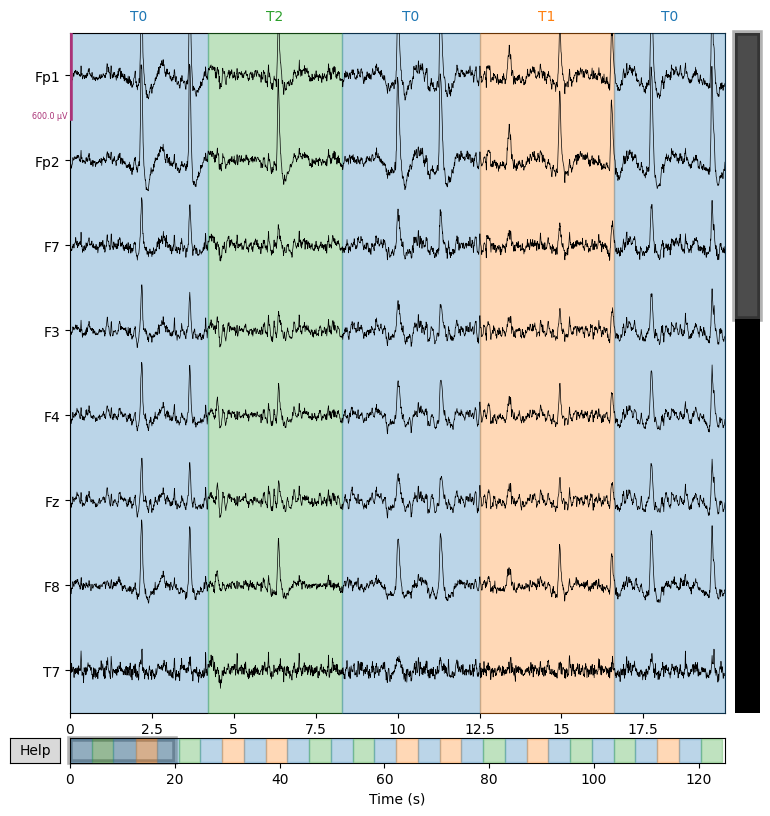

In [24]:
# Plot in better scale. Use 'scalings' argument
sample_1020.plot(n_channels=8, duration=20, scalings=3e-4)

###  Event Detection: Triggers vs Annotations

In EEG processing, correctly identifying events (e.g., stimulus onsets, task markers) is critical for epoching and downstream analysis. MNE-Python offers different tools depending on how these events are encoded in your file format:

- Use **`mne.find_events`** when events are stored in a dedicated trigger channel (common in FIFF/BDF formats).
- Use **`mne.events_from_annotations`** when events are embedded as annotations/markers (typical for EDF+ or BrainVision with annotations).

#### Why it matters for your data
In our case, we're working with EDF+ files (e.g., `S003R03.edf`). That means the events are stored as annotations, not trigger channels—so we should use `mne.events_from_annotations()` to properly extract them.


Next, we'll load the events and create epochs around them for further analysis.

In [25]:
events, events_dict = mne.events_from_annotations(sample_1020)

Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]


In [26]:
events_dict

{np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}

In [27]:
events[:5]

array([[   0,    0,    1],
       [ 672,    0,    3],
       [1328,    0,    1],
       [2000,    0,    2],
       [2656,    0,    1]])

```{admonition} Event array format in MNE:
:class: dropdown

[\text{sample\_index},\ \text{previous\_event\_code},\ \text{current\_event\_code}]
- sample_index – the time point (in samples) when the event occurs.
- previous_event_code – the code of the event/state before the change (often 0 in EDF+).
- current_event_code – the new event code that marks what actually happened.

👉 In EDF+ data, the middle column is usually 0 because events come from annotations, not from state changes.
```

###  Creating Epochs

Once we have identified the events of interest in our continuous Raw data, the next logical step is to segment the continuous EEG into **epochs** — short, equal-duration chunks of signal that are time-locked to each event. This is crucial because averaging across many such epochs allows us to reveal consistent brain responses (ERPs) while reducing random noise.

In MNE, the **Raw object** together with the **events array** is the minimal input needed to create an `Epochs` object  with the `mne.Epochs` class constructor. However, in practice we rarely use the defaults: we almost always want to specify the time window relative to each event, using the parameters `tmin` and `tmax` (start and end time of each epoch relative to the event). This ensures that our epochs capture both the pre-stimulus baseline and the post-stimulus response of interest.

We take 500 ms before the event as a baseline and 800 ms after the event to capture the main brain responses. This is a typical window for ERP analysis.

In [28]:
epochs = mne.Epochs(sample_1020, events,  tmin=-0.5, tmax=0.8, preload=True)

Not setting metadata
30 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 209 original time points ...
1 bad epochs dropped


We convert the list of events into a table and count how many times each event type occurs. 

In [29]:
pd.DataFrame(epochs.events, columns=['_', '__', 'event_id'])['event_id'].value_counts()

event_id
1    14
3     8
2     7
Name: count, dtype: int64

This is a quick way to check the class balance before creating Epochs.

In [30]:
# Take the first epoch from the Epochs object
for epoch in epochs:
    break
print(epoch.shape)  
# Output: (19, 209)
# -> 19 EEG channels × 209 time points
# Each epoch is stored as a 2D NumPy array (channels × samples)

# Compute the duration of a single epoch in seconds
epoch_duration = epoch.shape[1] / sample_1020.info['sfreq']
print(epoch_duration)  
# 209 samples / 160 Hz sampling rate ≈ 1.3 seconds
# This matches the chosen window: tmin = -0.5 s, tmax = 0.8 s

# Convert the raw object into a pandas DataFrame
print(sample_1020.to_data_frame().shape)  
# (20000, 20)
# -> 20,000 time points × 20 channels
# Each column corresponds to an EEG channel (plus 'time' if included)
# This format is convenient for quick inspection, plotting with pandas,
# or exporting EEG data to other analysis pipelines.

(19, 209)
1.30625
(20000, 20)


In [31]:
df = epochs.to_data_frame()
df.head(3).iloc[:, :10]

time condition  epoch         Fp1         Fp2          F7         F3  \
0 -0.50000         3      1  236.675891  244.275703  125.936913  88.829681   
1 -0.49375         3      1  175.970007  183.425016  103.803572  63.009365   
2 -0.48750         3      1  127.095181  132.985975   61.669835  31.478465   

           F4         Fz          F8  
0  112.445086  73.438632  145.805904  
1   82.687750  48.730906  115.749079  
2   62.299189  33.384794   93.870855

```{admonition} What we learn:
:class: dropdown

- We can see the raw numeric values (in µV) for each channel at each time point.
- Easy to check that metadata (condition, epoch) are aligned correctly.
```

#### Peak-to-peak amplitude (QC)

In [32]:
df[sample_1020.ch_names + ['epoch']].groupby('epoch').agg(lambda arr: arr.max() - arr.min()).hist(figsize=[10, 10]);
plt.tight_layout()

<IPython.core.display.Javascript object>

```{admonition} What we learn:
:class: dropdown

- A quick QC step: typical amplitudes and outliers.
- If Fp1/Fp2 show very large values → likely eye blinks or EOG.
- Helps justify setting a rejection threshold (e.g., reject={'eeg': 600e-6}).
```

In [33]:
epochs = mne.Epochs(sample_1020, events,  tmin=-0.5, tmax=0.8, reject={'eeg': 600e-6}, preload=True, baseline=(-.1, 0))

Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 209 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
15 bad epochs dropped


```{admonition} What we learn:
:class: dropdown

- How many epochs are rejected and why.
- Clean dataset for ERP analysis.
```

#### PSD of epochs

Compute and plot the Power Spectral Density across epochs.

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


<IPython.core.display.Javascript object>

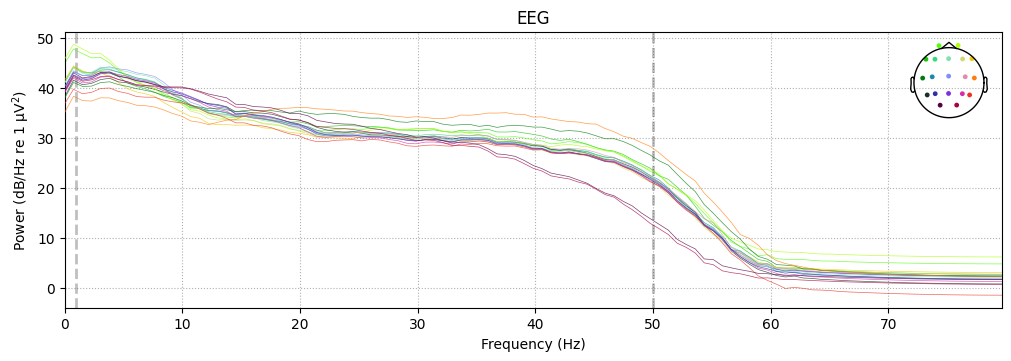

In [34]:
epochs.plot_psd()

```{admonition} What we learn:
:class: dropdown

- EEG shows the typical 1/f spectrum.
- <1 Hz drift and >50 Hz noise are cut off.
- No sharp spike at 50/60 Hz → line noise is not dominant.
```

Check that baseline correction and filtering worked properly

<IPython.core.display.Javascript object>

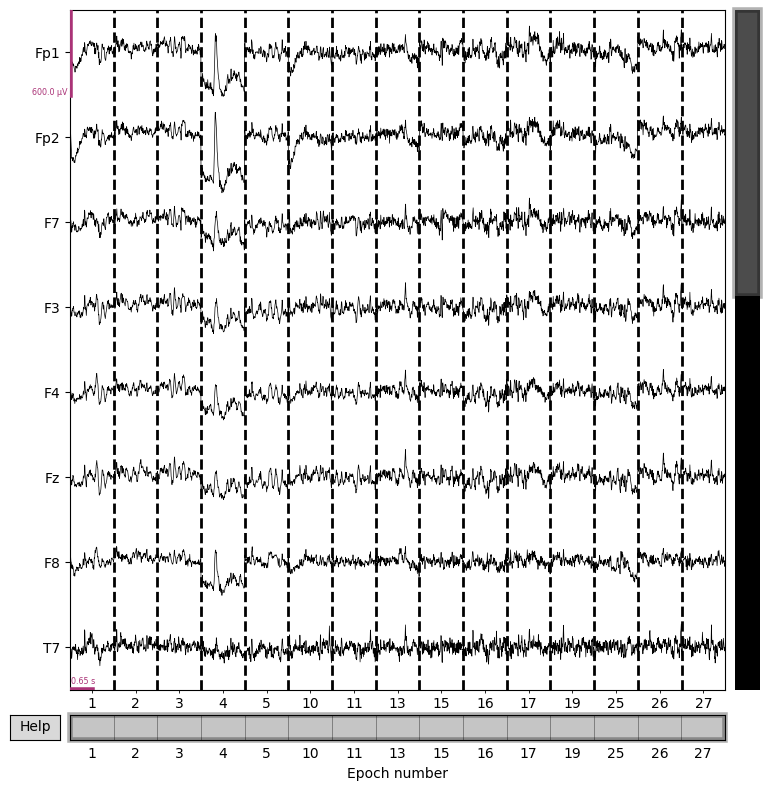

In [35]:
epochs.plot(n_channels=8, scalings={'eeg':3e-4})

In [36]:
epochs.event_id

{'1': 1, '2': 2, '3': 3}

```{admonition} Checking number of events of each type (use epochs.events)
:class: dropdown

```python

pd.DataFrame(epochs.events, columns=['_', '__', 'event_id'])['event_id'].value_counts()```
```

In [37]:
pd.DataFrame(epochs.events, columns=['_', '__', 'event_id'])['event_id'].value_counts()

event_id
3    6
1    5
2    4
Name: count, dtype: int64

#### Averaging (Evoked responses)

In [38]:
evoked_T0 = epochs['1'].average()
evoked_T1 = epochs['2'].average()
evoked_T2 = epochs['3'].average()

<IPython.core.display.Javascript object>

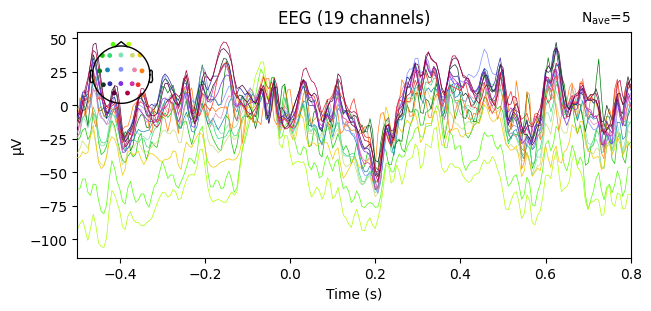

In [39]:
evoked_T0.plot(spatial_colors=True)

<IPython.core.display.Javascript object>

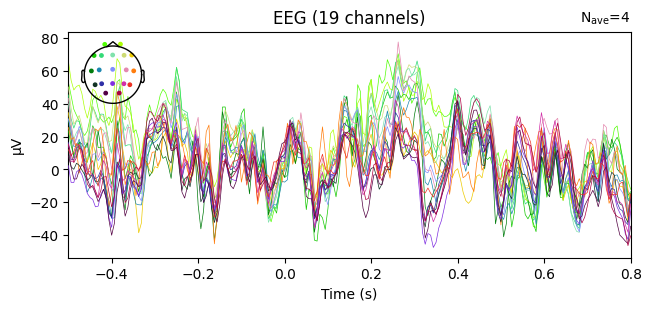

In [40]:
evoked_T1.plot(spatial_colors=True)

<IPython.core.display.Javascript object>

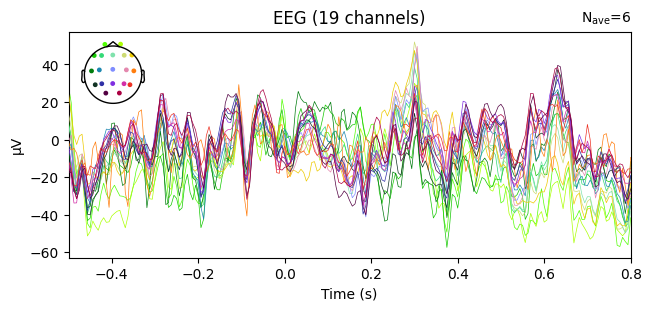

In [41]:
evoked_T2.plot(spatial_colors=True)

- Compute condition-specific averages (ERPs).
- Plot with spatial_colors=True so channels are colored by location.

```{admonition} What we learn:
:class: dropdown

- Inspect ERP morphology and possible lateralization (C3/Cz/C4 for motor tasks).
- Check N_avg in the top corner = how many epochs survived rejection.
- If T1 vs T2 have very different N_avg, keep this in mind for statistical comparisons.
```

## Part 2


### Independent Component Analysis (ICA) for Artifact Removal

Independent Component Analysis (ICA) is a method for estimating independent sources from mixed signals.  


![](https://scikit-learn.org/stable/_images/sphx_glr_plot_ica_blind_source_separation_001.png)

In EEG, ICA is applied to identify and remove **artifacts** — signal components not generated by neural activity.


#### Common Types of EEG Artifacts

Artifacts can be divided into **physiological** (originating from the human body but not the brain) and **non-physiological/technical** (external or recording-related):

- **Physiological artifacts**  
  - Ocular activity (blinks, saccades)  
  - Muscle activity (EMG from face, jaw, or neck)  
  - Cardiac activity (ECG leakage)  
  - Perspiration (sweat-induced drifts)  
  - Respiration (movement-related fluctuations)  

- **Non-physiological / Technical artifacts**  
  - Electrode pops (sudden impedance changes)  
  - Cable movement (mechanical noise)  
  - Incorrect reference electrode placement  
  - AC line noise (50/60 Hz) and electromagnetic interference  
  - Gross body movements  


**Further resources:**  
- [Types of EEG artifacts](https://www.learningeeg.com/artifacts)  
- [Detecting artifacts with ICA](https://www.bitbrain.com/blog/eeg-artifacts)

In [71]:
ica = mne.preprocessing.ICA(n_components=10, random_state=42)

At this stage, **no computation is performed yet** — we are only creating an *empty ICA object* with chosen parameters.  
Think of it as preparing a **container** where the following will be stored later:

- **Mixing matrix (A):** how independent components (ICs) project back into EEG channels.  
- **Unmixing matrix (W):** how EEG channels can be decomposed into independent components.  
- **IC time series and topographies** after fitting.


In [72]:
ica.fit(sample_1020)

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 0.1s.


<ICA | raw data decomposition, method: fastica (fit in 17 iterations on 20000 samples), 10 ICA components (19 PCA components available), channel types: eeg, no sources marked for exclusion>

The actual unmixing of EEG channels into independent components happens **only when we call**:

```python
ica.fit(sample_1020)
```

#### Explained variance ratio

- What it does: estimates how much of the EEG variability is explained by the selected ICs.
- Why: a sanity check — to verify whether the chosen number of components is sufficient and whether important signal is preserved in reconstruction.
- What to look for: values around ~0.95–0.99 for EEG are usually considered good.

In [73]:
explained_var_ratio = ica.get_explained_variance_ratio(sample_1020)
for channel_type, ratio in explained_var_ratio.items():
    print(f"Fraction of {channel_type} variance explained by all components: {ratio}")

Fraction of eeg variance explained by all components: 0.9738186007059333


Display the time courses of all independent components (IC000, IC001, …).
The colored bars at the top correspond to experimental segments T0/T1/T2.

**Why.** To quickly spot repeating artifacts (blinks, EMG, ECG) and identify the intervals where they appear.

Creating RawArray with float64 data, n_channels=10, n_times=20000
    Range : 0 ... 19999 =      0.000 ...   124.994 secs
Ready.


<IPython.core.display.Javascript object>

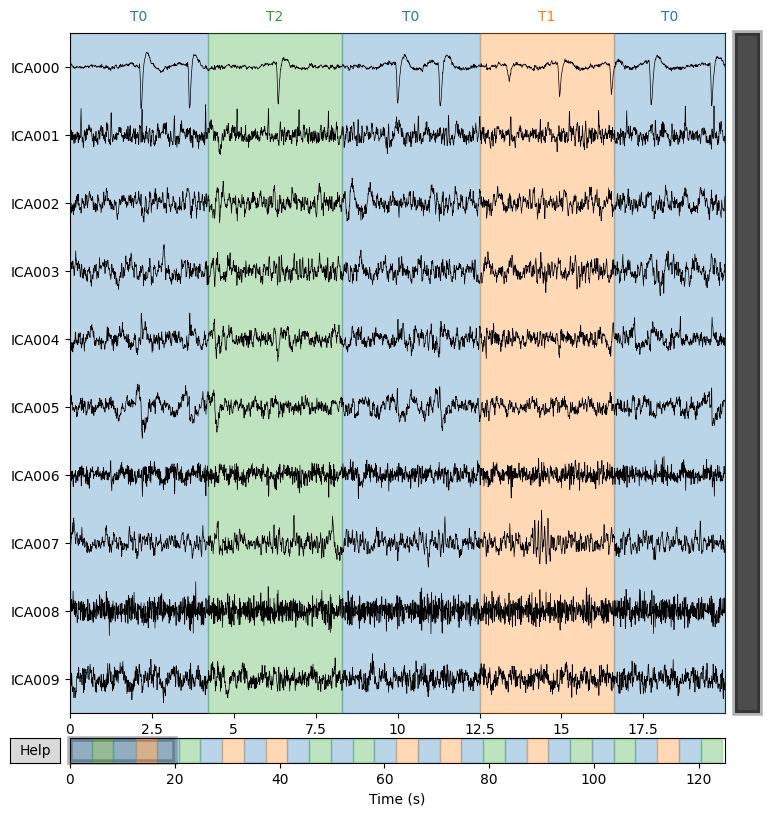

In [74]:
ica.plot_sources(sample_1020)

```{admonition} What we learn:
:class: dropdown

What to look for.
- Large sharp peaks repeating in bursts → typically eye blinks (EOG).
- High-frequency “roughness” → muscle activity (EMG).
- Regular ~1 Hz waves → ECG.
- Stable, smooth traces with rhythmic patterns → usually neural ICs.

Typical conclusion. Select 1–3 “suspicious” ICs for detailed inspection in the next step.
```

Examine the scalp maps of IC contributions (mixing topographies)

<IPython.core.display.Javascript object>

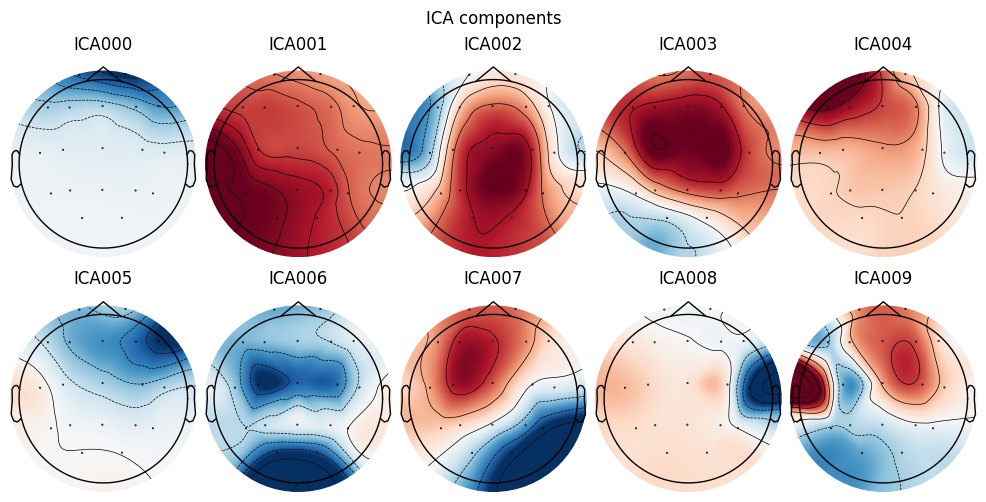

In [75]:
ica.plot_components()

```{admonition} What we learn:
:class: dropdown

Topography is the key to identifying the type of artifact:
- Symmetry across the forehead (Fp1/Fp2) → EOG/blinks.
- Localized patches near the temples/cheeks → EMG.
- Dipole-like pattern closer to the center/lower head → possible ECG.
- Occipital dominance with alpha activity → often a neural IC.

What to look for. Combine with the time-course analysis:
suspicious temporal dynamics + a “matching” artifact topography = a strong candidate for exclusion.

```



Analyze IC007 in detail: topography, time course, PSD, and variance across segments.

**Why.** To distinguish neural components from artifact components using multiple criteria.


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated


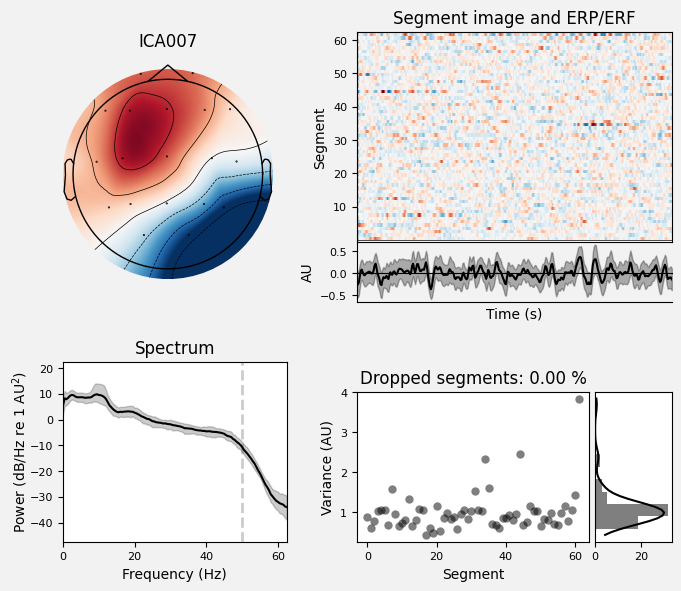

[<Figure size 700x600 with 6 Axes>]

In [83]:
ica.plot_properties(sample_1020, picks=[7])

```{admonition} What we learn:
:class: dropdown

What to look for.
- Topography: is it physiologically plausible for brain/activity or for a specific artifact?
- Spectrum (PSD): are there α (8–13 Hz) / β (13–30 Hz) peaks and an overall ~1/f falloff?
A narrow spike at 50/60 Hz → line noise; a broad high-frequency floor → EMG.
- Time series: any large, sharp transients (suggestive of EOG/blinks)?
- Variance across segments: many outliers (instability → more likely an artifact).

Typical criterion. A “good” IC shows a 1/f decay, possible α/β peak, no large transients, and a plausible topography.

```


Temporarily zero out ICs with indices [0,1,2] and compare the signals before (red) and after (black).

**Why.** To make sure that removing the selected ICs reduces artifacts without distorting useful neural dynamics.

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 3 ICA components
    Projecting back using 19 PCA components


<IPython.core.display.Javascript object>

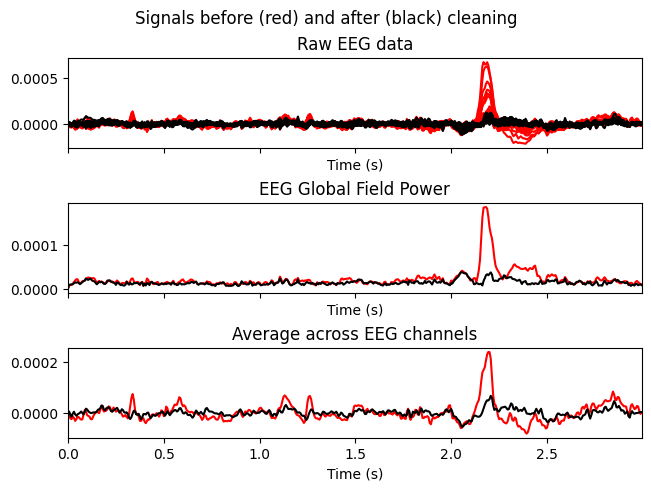

In [81]:
# blinks
ica.plot_overlay(sample_1020, exclude=[0,1,2])

```{admonition} What we learn:
:class: dropdown

What to look for.
- Blink/EMG peaks should be clearly reduced.
- Physiological rhythms (e.g., alpha) should not disappear globally.

Important. This is only a preview — the raw data have not been modified yet.

```

Examine how excluding ICs [0,1] affects a specific channel (F3).

**Why.** To check the local effect in regions where artifacts are most noticeable (often frontal channels).

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components


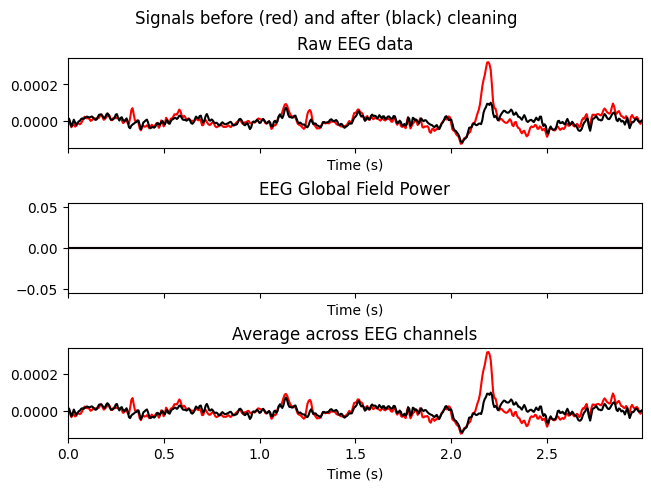

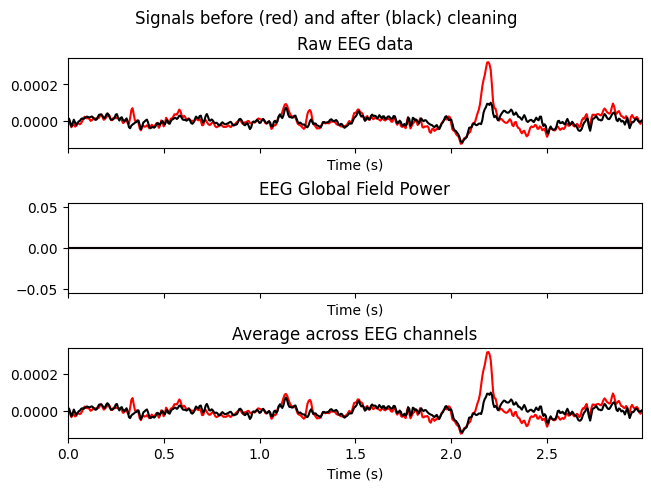

In [84]:
ica.plot_overlay(sample_1020, exclude=[0, 1], picks=['F3'])

```{admonition} What we learn:
:class: dropdown

What to look for. Reduction of spikes/“flickering” in F3 while preserving the overall shape of the response.

```

In [50]:
ica.exclude = [0,1]

**ICA000 (blue frontal component)**

- Topography: maximum strictly at the forehead, symmetric over Fp1/Fp2.

- Time course (from your ica.plot_sources): rare, very large sharp peaks.

- Spectrum: dominance of low frequencies, without regularity.

👉 This looks  like EOG (blinks).


**ICA001 (red “filled” component)**

- Topography: broader and deeper distribution, not only frontal but also extending downward/central.

- Time course: peaks appear more regular, repeating roughly every ~1 second.

- Spectrum: expected strong power around ~1–1.5 Hz.


👉 This is more consistent with ECG (heartbeat).


In [51]:
sample_1020_clr = sample_1020.copy()

In [52]:
ica.apply(sample_1020_clr)

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components


<RawEDF | S003R03.edf, 19 x 20000 (125.0 s), ~2.9 MiB, data loaded>

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components


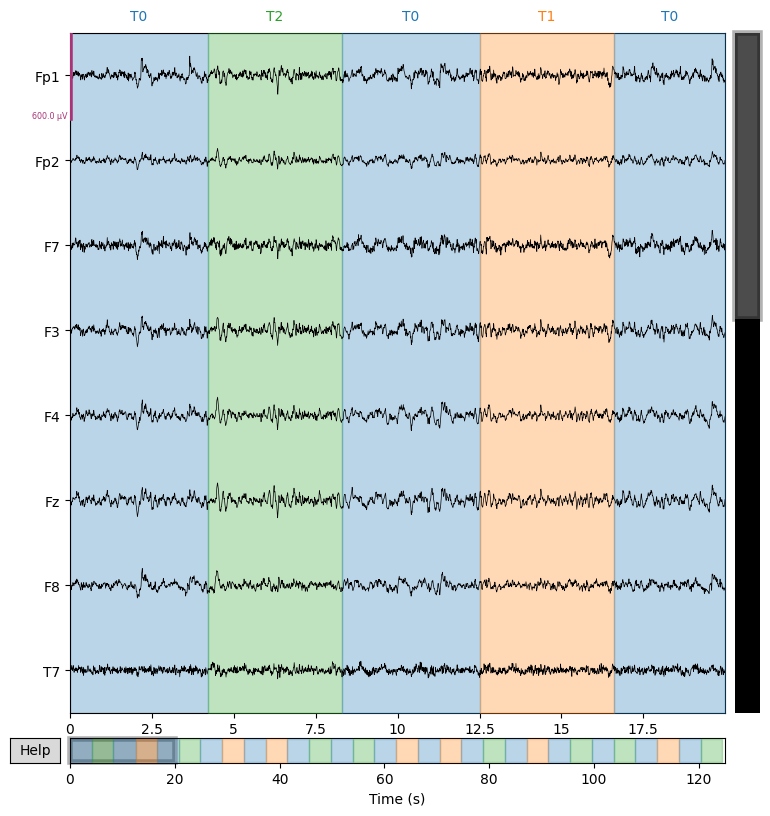

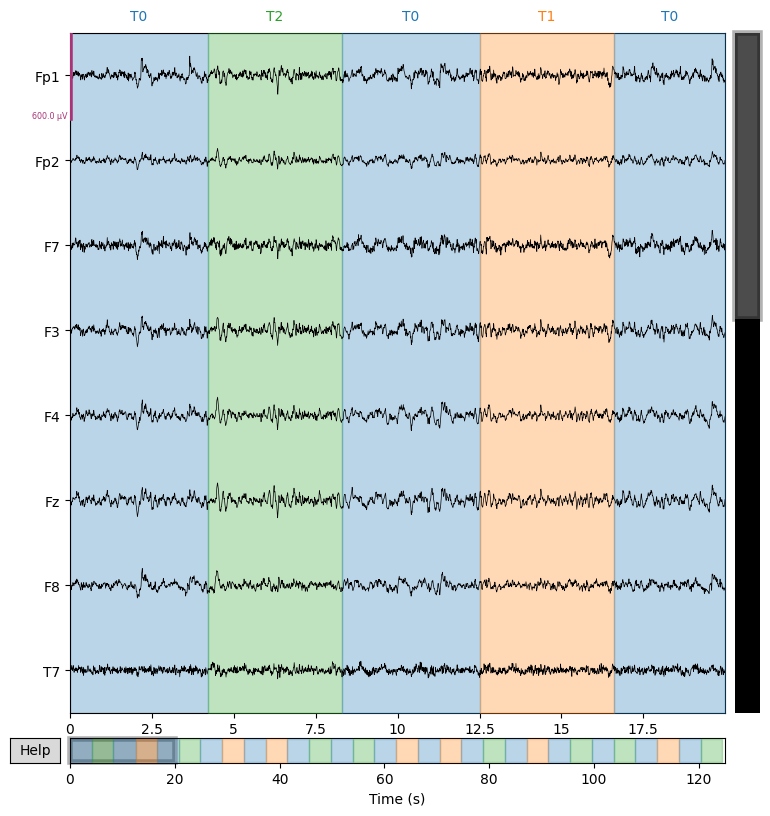

In [87]:
# Apply the ICA to remove the chosen components from the data
cleaned_eeg = ica.apply(sample_1020_clr)

# Plot the cleaned signals after excluding the chosen artifacts
cleaned_eeg.plot(n_channels=8, duration=20, scalings=3e-4)

In [88]:
epochs = mne.Epochs(sample_1020_clr, events,  tmin=-0.5, tmax=0.8, reject={'eeg': 600e-6}, preload=True, baseline=(-.1, 0))


Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 209 original time points ...
1 bad epochs dropped


In [89]:
evoked_T0 = epochs['1'].average()
evoked_T1 = epochs['2'].average()
evoked_T2 = epochs['3'].average()

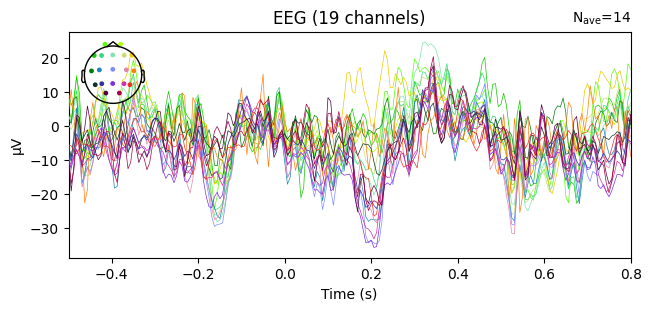

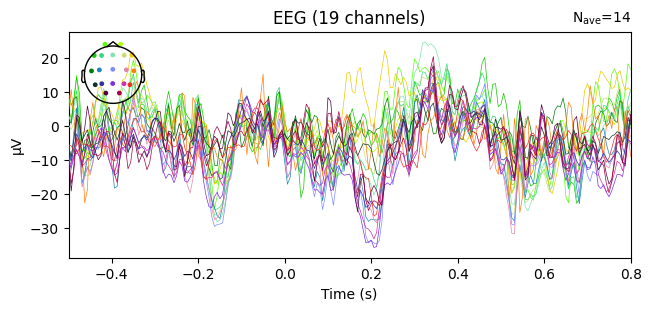

In [90]:
evoked_T0.plot(spatial_colors=True)

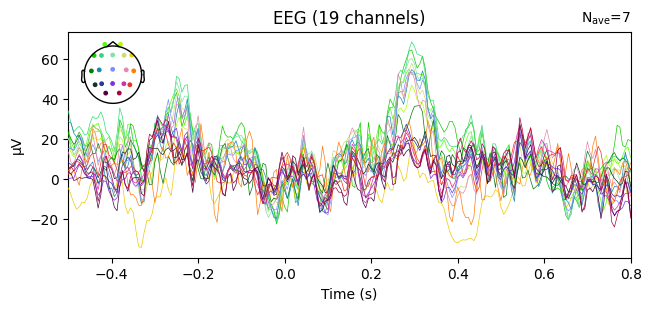

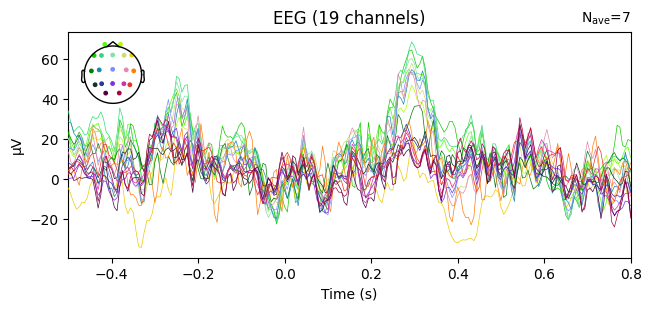

In [91]:
evoked_T1.plot(spatial_colors=True)

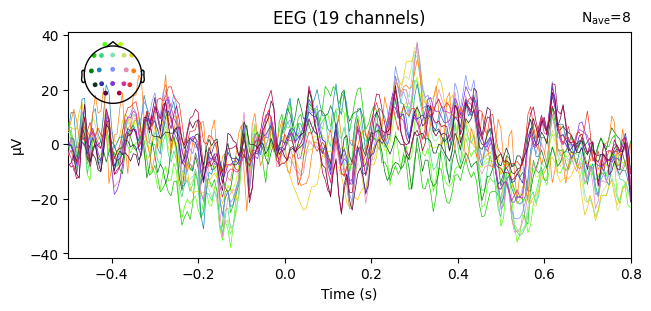

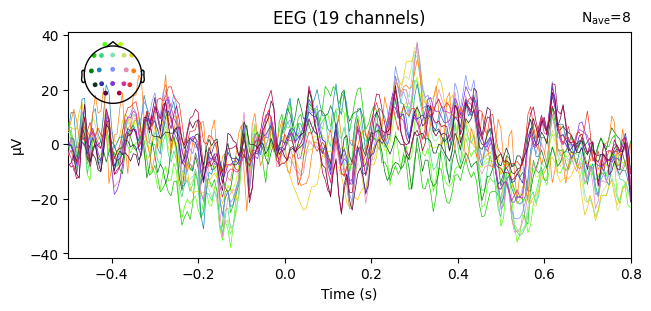

In [92]:
evoked_T2.plot(spatial_colors=True)


### Global Field Power (GFP)

It is useful to look at **Global Field Power (GFP)**.  
GFP summarizes how much the EEG signals vary across all electrodes at each time point.

- If all sensors record the **same value**, there is no spatial variability → **GFP = 0**.  
- If the sensors differ strongly, GFP increases → **GFP > 0**.  

In practice, **GFP peaks highlight moments of strong, widespread brain activity** (for example, event-related potentials).  
Therefore, GFP is often used as a quick overview to identify time periods that may be worth a closer look.

Let’s plot a comparison of averaged evoked responses (ERPs) across the three conditions:
- rest (T0) — resting state,
- left (T1) — imagination/movement of the left hand,
- right (T2) — imagination/movement of the right hand.

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


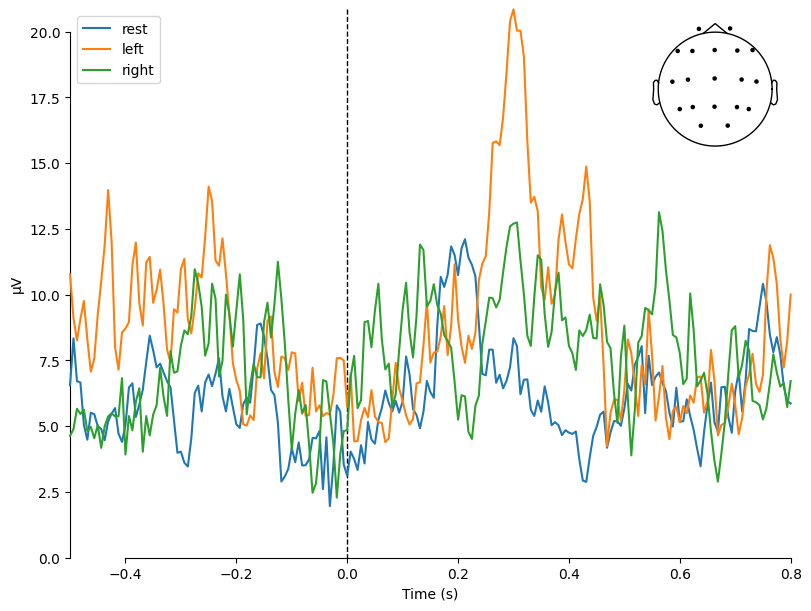

[<Figure size 800x600 with 2 Axes>]

In [93]:
mne.viz.plot_compare_evokeds(
    dict(rest=evoked_T0, left=evoked_T1, right=evoked_T2),
    legend="upper left",
    show_sensors="upper right",
)

#### Visualizing Evoked responses in more detail

To explore evoked responses, MNE provides two useful plotting methods:

1. **`plot_joint`**  
   - Combines the ERP time course with **topographic scalp maps**.  
   - On the left: the ERP curve across time.  
   - On the right: scalp maps showing the spatial distribution of activity at specific time points.  
   - 👉 This helps to connect **when** something happens with **where** on the scalp it is strongest.

2. **`plot_topomap`**  
   - Shows only the scalp maps at selected time points.  
   - Useful if we want to focus on the **spatial distribution** of brain activity.



#### How to choose the time points
- We can **set them manually**, e.g. `times=[0.1, 0.3, 0.5]` (in seconds).  
- Or we can let MNE choose automatically with `times='peaks'`.  
  - In this case, MNE looks at the **Global Field Power (GFP)** curve.  
  - GFP measures how strong and synchronized the brain’s response is across the scalp.  
  - MNE finds the **3 strongest peaks** in GFP.  
  - These peaks usually correspond to meaningful ERP components (like P100, N200, P300).  

No projector specified for this dataset. Please consider the method self.add_proj.


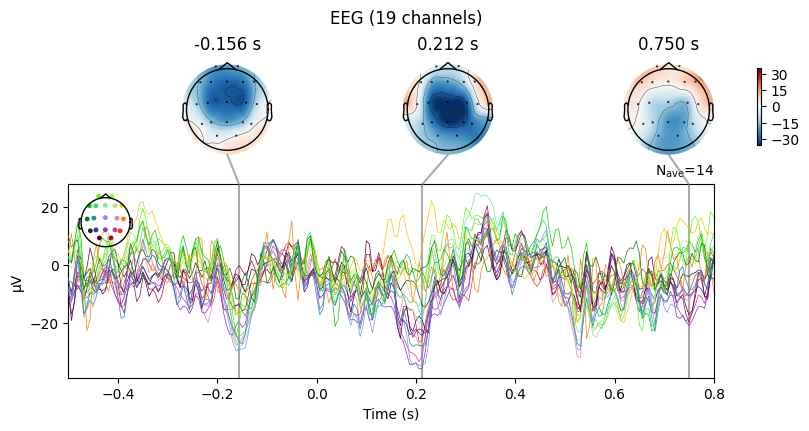

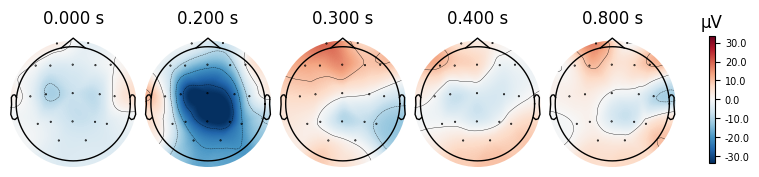

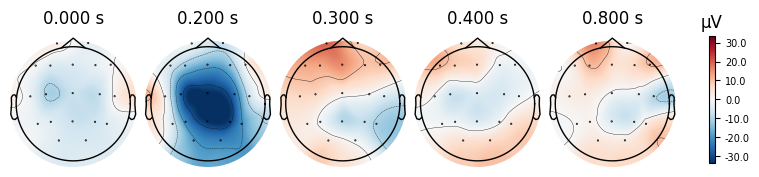

In [94]:
evoked_T0.plot_joint()
evoked_T0.plot_topomap(times=[0.0, 0.2, 0.3, 0.4, 0.8])

No projector specified for this dataset. Please consider the method self.add_proj.


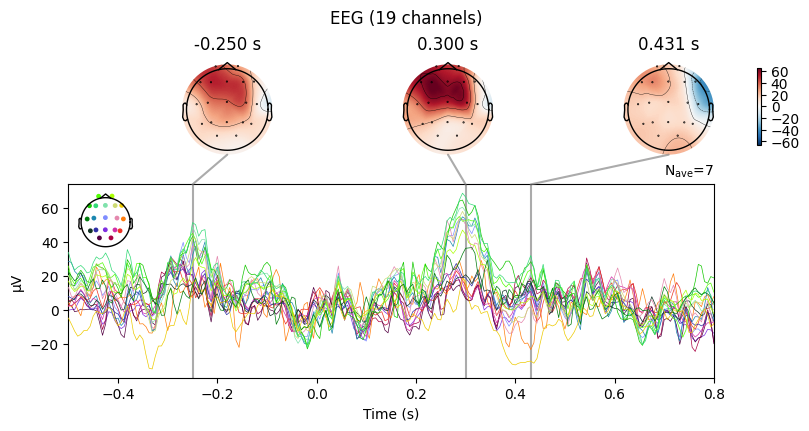

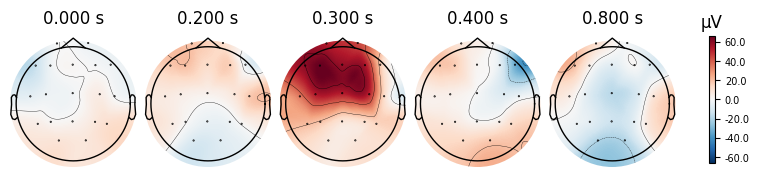

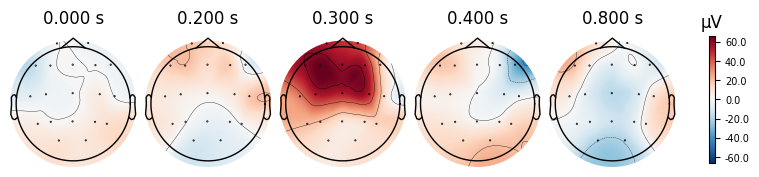

In [95]:
evoked_T1.plot_joint()
evoked_T1.plot_topomap(times=[0.0, 0.2, 0.3, 0.4, 0.8])

No projector specified for this dataset. Please consider the method self.add_proj.


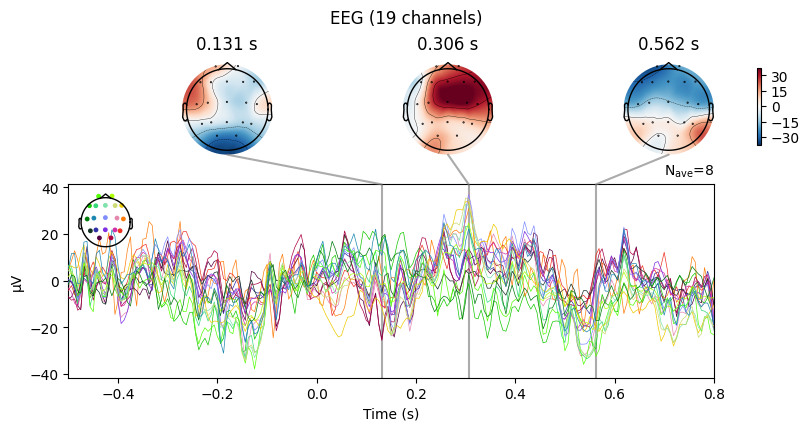

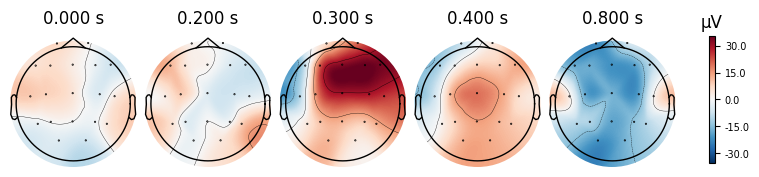

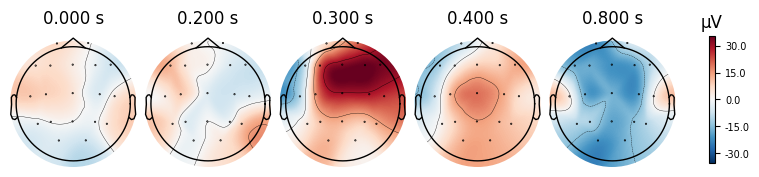

In [96]:
evoked_T2.plot_joint()
evoked_T2.plot_topomap(times=[0.0, 0.2, 0.3, 0.4, 0.8])

```{admonition} What we learn:
:class: dropdown

What to look for.
- On the **ERP time course**: check where the peaks occur.  
- On the **topomaps**: see which brain regions (frontal, central, parietal, occipital) are most active at those times.  

``` 

### Functional Connectivity in EEG

So far, we have mainly looked at **local activity** of the brain:  
- ERPs show the average response over time in each condition.  
- Topomaps reveal where on the scalp the strongest signals occur.  
- GFP summarizes overall synchrony across sensors.  

But brain function is not only about **local activations**.  
It also depends on **interactions between different brain regions** — how signals from one area are related to signals from another.  
This is called **functional connectivity**.



#### Spectral Connectivity

Connectivity is often estimated in the **frequency domain**:  
- We check if oscillations in two channels are synchronized at certain frequencies.  
- One popular measure is **coherence (`coh`)**, which quantifies how consistently two signals oscillate together.  
- High coherence means the two brain regions are likely interacting or sharing information.


In [97]:
conn_T1 = mne_connectivity.spectral_connectivity_epochs(epochs['2'], method='coh')

Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 171 connections
    using t=-0.500s..0.800s for estimation (209 points)
    frequencies: 4.6Hz..79.6Hz (99 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    assembling connectivity matrix
[Connectivity computation done]


```{admonition} What we learn:
:class: dropdown

What to look for.
- Which pairs of channels show the highest coherence?
- In which frequency bands (e.g., alpha, beta) is connectivity strongest?
- How does connectivity differ between conditions (rest vs. left vs. right)?

``` 

This function transforms the connectivity matrix (NxN) into a graph on the scalp, making it easy to see which brain areas work synchronously.

In [98]:
def plot_topomap_connectivity_2d(info, con, picks=None, pairs=None, vmin=None, vmax=None, cm=None, show_values=False, show_names=True):
    """
    Plots connectivity-like data in 2d

    Drawing every pair of channels will likely make a mess
    There are two options to avoid it:
    - provide picks
    - provide specific pairs of channels to draw
    """

    # get positions
    _, pos, _, _, _, _, _ = mne.viz.topomap._prepare_topomap_plot(info, 'eeg');

#     if picks is None and pairs is None:
#         picks = info.ch_names

    ch_names_lower = [ch.lower() for ch in info.ch_names]
    if picks:
        picks_lower = [ch.lower() for ch in picks]
    if pairs:
        pairs_lower = [tuple(sorted([ch1.lower(), ch2.lower()])) for ch1, ch2 in pairs]

    rows = []
    for idx1, ch1 in enumerate(ch_names_lower):
        for idx2, ch2 in enumerate(ch_names_lower):
            if ch1 >= ch2:
                continue
            if picks and (ch1 not in picks_lower or ch2 not in picks_lower):
                    continue
            if pairs and (ch1, ch2) not in pairs_lower:
                    continue
            rows.append((
                pos[idx1],
                pos[idx2],
                con[idx1, idx2]
            ))

    if not len(rows):
        raise ValueError('No pairs to plot')

    con_to_plot = np.array([row[2] for row in rows])
    if vmin is None:
        vmin = np.percentile(con_to_plot, 2)
    if vmax is None:
        vmax = np.percentile(con_to_plot, 98)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

    if cm is None:
        cm = sns.diverging_palette(240, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=[5, 5])
    mne.viz.utils.plot_sensors(info, show_names=show_names, show=False, axes=ax);
    for row in rows:
        if (row[2] > vmin) and  (row[2] < vmax):
          rgba_color = cm(norm(row[2]))
          plt.plot([row[0][0], row[1][0]], [row[0][1], row[1][1]], color=rgba_color)
          if show_values:
              plt.text((row[0][0] + row[1][0]) / 2,
                      (row[0][1] + row[1][1]) / 2,
                      '{:.2f}'.format(row[2]))

What we can  see in the figure:

- Black dots → electrode positions (Fp1, Fp2, Cz, O1, etc.).

- Lines between them → coherence values.

- Red/thicker lines → stronger connections.

- Blue/thinner lines → weaker connections.


Compute spectral connectivity (coherence) for each condition

In [99]:
conn_T0 = mne_connectivity.spectral_connectivity_epochs(epochs['1'], method='coh', verbose=False)
conn_T1 = mne_connectivity.spectral_connectivity_epochs(epochs['2'], method='coh', verbose=False)
conn_T2 = mne_connectivity.spectral_connectivity_epochs(epochs['3'], method='coh', verbose=False)

- For rest (T0), left hand movement/imagery (T1), and right hand movement/imagery (T2), we compute coherence between all pairs of EEG channels.
- Output: a 3D matrix → (channels × channels × frequencies).

Check the shape of the result

In [100]:
conn_T0.get_data(output="dense").shape

(19, 19, 99)

- 19 EEG channels × 19 EEG channels × 99 frequency bins.
- This is the full coherence tensor across the scalp.


Average across frequencies (1–50 Hz)

In [101]:
conn_T0_all = conn_T0.get_data(output="dense")[:, :, 1:50].mean(axis=2)
conn_T0_all = conn_T0_all + conn_T0_all.T

conn_T1_all = conn_T1.get_data(output="dense")[:, :, 1:50].mean(axis=2)
conn_T1_all = conn_T1_all + conn_T1_all.T

conn_T2_all = conn_T2.get_data(output="dense")[:, :, 1:50].mean(axis=2)
conn_T2_all = conn_T2_all + conn_T2_all.T

- Select frequencies from 1 to 50 Hz.
- Average coherence values over this range → one mean connectivity matrix (19×19).
- Add its transpose to make it symmetric (since coherence is theoretically symmetric).

The same procedure is applied for T1 and T2.

Visualize the connectivity on the scalp

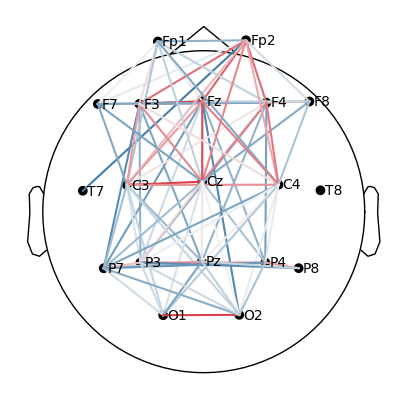

In [102]:
plot_topomap_connectivity_2d(epochs.info, conn_T0_all, picks=epochs.ch_names, vmin=0.5)

- Take the coherence matrix (e.g., for T0).
- Plot electrodes as nodes (black dots) and coherence values as edges (lines).
- Only strong connections above 0.5 are displayed:
    - red/thicker lines = strong coherence,
    - blue/thinner lines = weaker coherence.

```{admonition} What we learn:
:class: dropdown

What to look for.  
- When plotting connectivity for **T1 (left hand)** and **T2 (right hand)**, adjust the parameter `vmin`.  
- `vmin` defines the **minimum connectivity value** shown on the color scale.  
- By increasing `vmin`, only the **strongest connections** are displayed, making it easier to see condition-specific differences.  

How to interpret.  
- Compare the **patterns of strong links** (red edges) between T1 and T2.  
- Focus on whether the central electrodes (C3/C4) show stronger coherence with other areas depending on the imagined hand movement.  

``` 

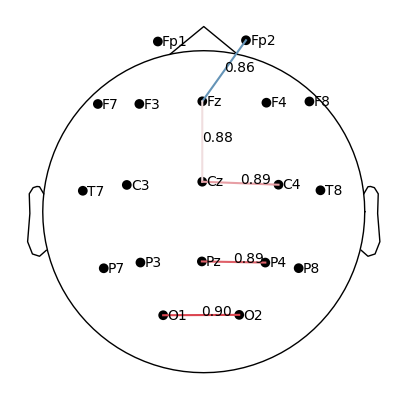

In [105]:
plot_topomap_connectivity_2d(epochs.info, conn_T1_all, picks=epochs.ch_names,  show_values=True, vmin=0.85)

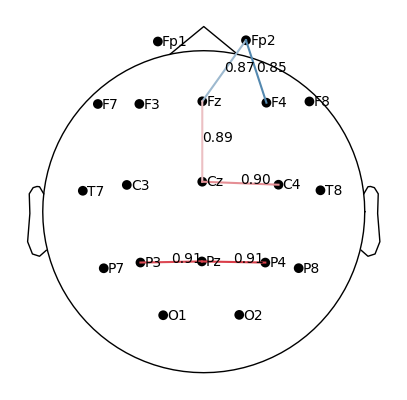

In [106]:
plot_topomap_connectivity_2d(epochs.info, conn_T2_all, picks=epochs.ch_names,  show_values=True, vmin=0.85)

```{admonition} Beta-band coherence analysis
:class: dropdown

**What we do.**  
- Compute functional connectivity (coherence) in the **beta band (12–20 Hz)**.  
- Focus only on **selected pairs of channels** instead of plotting all-to-all connections.  
- Use the helper function `plot_topomap_connectivity_2d` with the argument  
  `pairs=[('F7', 'F4'), ('O2', 'T7'), ...]`.

**Why.**  
- Beta activity (12–20 Hz) is strongly linked to the **motor cortex**.  
- Coherence in this band reflects how well different brain regions are synchronized during motor tasks.  
- By restricting to 5–10 meaningful pairs, we highlight the most relevant motor and control connections without clutter.

**What to look for.**  
- Stronger coherence between **C3/Cz/C4** and frontal/parietal regions → motor network engagement.  
- Differences between **T1 (left hand)** and **T2 (right hand)** conditions, reflecting lateralized motor control.  
- Red/thicker lines indicate strong synchronization; blue/thinner lines indicate weaker links.

```